In [1]:
import pandas as pd
import random
import torch
import numpy as np

from PIL import Image

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
target_label_names = ['MEL', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC', 'NV']

In [3]:
labels = pd.read_csv('../data/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv',
                    dtype={**{'image': str},
                           **{label: int for label in target_label_names}})
labels.image += '.jpg'

In [4]:
labels.head(3)

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306.jpg,0,1,0,0,0,0,0
1,ISIC_0024307.jpg,0,1,0,0,0,0,0
2,ISIC_0024308.jpg,0,1,0,0,0,0,0


In [5]:
class CachingImagesDataset(Dataset):
    def __init__(self, df, images_folder, label_columns,
                 transform=None, cache_prob=-1,
                 image_filename_column='image'):
        self.df = df
        
        self.transform = transform
        
        self.cache_prob = cache_prob
        self.cache = dict()
        
        self.images_folder = images_folder
        self.image_filename_column = image_filename_column
        self.label_columns = label_columns
        
    def process_new_item(self, index):
        row = self.df.iloc[index]
        file_path = self.images_folder + row[self.image_filename_column]
        with open(file_path, 'rb') as f:
            image = Image.open(f).convert('RGB')
#         image = cv2.imread(self.images_folder + row[self.image_filename_column])[:, :, ::-1]
        labels = row[self.label_columns]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, labels
    
    def process_cached_item(self, index):
        return self.cache.get(index, None)

        
    def __getitem__(self, index):
        result = None
        if random.random() < self.cache_prob:
            result = self.process_cached_item(index)
        
        if result is None:
            result = self.process_new_item(index)
            if self.cache_prob > 0:
                self.cache[index] = result
                
        return result
    
    def __len__(self):
        return len(self.df)

In [6]:
transformer = transforms.Compose([
    transforms.RandomRotation(degrees=(0, 90)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

In [7]:
dataset = CachingImagesDataset(labels, images_folder='../data/ISIC2018_Task3_Training_Input/',
                               label_columns=target_label_names,
                               transform=transformer,
                               cache_prob=0.1)

In [8]:
loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4,
                    pin_memory=torch.cuda.is_available())

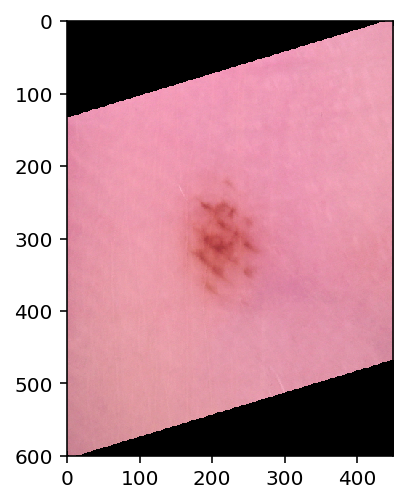

In [9]:
plt.imshow(loader.dataset[322][0].numpy().transpose());